# Recursive algorithm for kidney exchanges

In this notebook, I implement the recursive algorithm introduced in [Anderson et al (2015), "Kidney Exchange and the Alliance for Paired Donation: Operations Research Changes the Way Kidneys Are Transplanted"](https://dspace.mit.edu/handle/1721.1/111107).

In [1]:
using Pkg

In [2]:
using Graphs, GraphPlot
using Random
using StatsBase
using Distributions
using JuMP

import HiGHS

In [15]:
Random.seed!(42);

## Create a random graph

First I create a random graph of incompatible pairs.
I consider two kinds of compatibility: tissue compatibility and blood-type compatibility.
For the tissue compatibility, I assume that a donor is compatible to a patient with probability $p$, and for the blood-type compatibility, I randomly sample blood-types of patients and donors and consider compatibility between pairs.
I consider two pairs are compatible if they are both tissue compatible and blood-type compatible.

In [16]:
pairs = "Pair_" .* string.(collect('A':'Z'));
numPairs = length(pairs);

In [17]:
bloodTypeVec = vec([join(x, "_") for x in Iterators.product(["A", "B", "O", "AB"], ["A", "B", "O", "AB"])]);

In [18]:
pairBloodTypes = sample(bloodTypeVec, numPairs, replace=true);

In [19]:
ABOCompatibility = Dict([("O", ["O", "A", "B", "AB"]), ("A", ["A", "AB"]), ("B", ["B", "AB"]), ("AB", ["AB"])]);

In [20]:
pairABOCompatibilityMatrix = zeros(Int, numPairs, numPairs);

for i = 1:numPairs, j = 1:numPairs
    if i ≠ j
        donorBloodType = split(pairBloodTypes[i], "_")[2]
        patientBloodType = split(pairBloodTypes[j], "_")[1]
        if patientBloodType in ABOCompatibility[donorBloodType]
            pairABOCompatibilityMatrix[i, j] = 1
        end
    end
end

In [21]:
p = 0.12;
N = numPairs * numPairs;
d = Binomial(1, p);

pairTissueCompatibilityMatrix = reshape(rand(d, N), numPairs, numPairs);
for i = 1:numPairs
    pairTissueCompatibilityMatrix[i, i] = 0
end

In [22]:
pairCompatibilityMatrix = pairABOCompatibilityMatrix .* pairTissueCompatibilityMatrix;

Also, later I introduce a non-directed donor.
For a fair comparison, I assume that all donors are acceptable to the patient in Pair A.

In [23]:
pairCompatibilityMatrix[:, 1] .= 1;
pairCompatibilityMatrix[1, 1] = 0;

Here is the figure of a directed network.

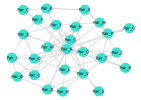

In [24]:
g = SimpleDiGraph(pairCompatibilityMatrix);
gplot(g, nodelabel=pairs, NODESIZE=0.09, arrowlengthfrac=0.05)

There are 135 cycles in the graph, and the maximum length of cycles is 12.

In [25]:
println("Number of cycles: ", length(simplecycles(g)))
maxCycleLength = maximum([length(x) for x in simplecycles(g)])
println("Maximum length of cycles: ", maxCycleLength)

for cycle in simplecycles(g)
    if length(cycle) == maxCycleLength
        println([pairs[x] for x in cycle])
    end
end

Number of cycles: 135
Maximum length of cycles: 12
["Pair_A", "Pair_E", "Pair_K", "Pair_X", "Pair_N", "Pair_G", "Pair_V", "Pair_H", "Pair_U", "Pair_I", "Pair_B", "Pair_Z"]
["Pair_A", "Pair_E", "Pair_Q", "Pair_D", "Pair_N", "Pair_G", "Pair_V", "Pair_H", "Pair_U", "Pair_I", "Pair_B", "Pair_Z"]


## Formulation without bounds for cycle lengths

To obtain the cycles maximizing the number of exchanges, I solve the following maximization problem with $w_e = 1$ for all edges $e$:

\begin{align}
    &\max_{\{y_e\}} \sum w_e y_e \\ 
    \text{subject to} 
    & \sum_{e \in out(v)} y_e \le \sum_{e \in in(v)} y_e \quad \text{for every pair $v$} \\
    & \sum_{e \in in(v)} y_e \le 1 \quad \text{for every pair $v$} \\
    & y_e \in \{0, 1 \}.
\end{align}

Here $in(v)$ and $out(v)$ are the sets of edges that point to or are outgoing from a node $v$, respectively.
The idea follows a [maximum flow problem](https://en.wikipedia.org/wiki/Maximum_flow_problem) to find a maximum possible flow from a feasible flow network.
The first constraint corresponds to the flow conservation constraint, and the second constraint corresponds to the capacity constraint.

Note that this does not impose any restriction on the length of cycles.
The code below solves this problem.

In [38]:
max_flow = Model(optimizer_with_attributes(HiGHS.Optimizer, "output_flag" => false))
@variable(max_flow, 1 >= f[1:numPairs, 1:numPairs] >= 0, Int)
# Capacity constraints
@constraint(max_flow, [i = 1:numPairs, j = 1:numPairs], f[i, j] <= pairCompatibilityMatrix[i, j])
@constraint(max_flow, [j = 1:numPairs], sum(f[:, j]) <= 1)
# Flow conservation constraints
@constraint(max_flow, [i = 1:numPairs], sum(f[i, :]) <= sum(f[:, i]))

@objective(max_flow, Max, sum(f))
optimize!(max_flow)


The solution is as follows.
We can see that there is a very long cycle, which is operationally difficult since operations in a cycle need to be conducted simultaneously to prevent back-out of donors.
In the next part, I introduce a recursive algorithm to impose such cycle length restrictions.

In [40]:
println("Number of exchanges: ", Int(objective_value(max_flow)))
for cycle in simplecycles(SimpleDiGraph(value.(f)))
    println([pairs[x] for x in cycle])
end

Number of exchanges: 16
["Pair_A", "Pair_E", "Pair_Q", "Pair_D", "Pair_N", "Pair_G", "Pair_V", "Pair_H", "Pair_U", "Pair_I", "Pair_B", "Pair_Z"]
["Pair_K", "Pair_X"]
["Pair_O", "Pair_P"]


## Recursive formulation

To avoid to have long cycles in a solution, after solving the maximization problem, I add the following restriction:
$$
    \text{For each cycle $C$ whose length $> C_{max}$ }, \sum_{e \in C} y_e \ge |C| - 1.
$$
This guarantees that the long cycle found in the previous optimization problem is removed from the following solution.
I recursively add such constraint until I do not get any long cycles.
The code below implements this idea, where the maximum length of cycle is set to be 3.

In [41]:
cycleAdjacencyMatrixList = [];
cycleLengthList = [];
maxCycleLength = 3;
optimalSolutionMatrix = zeros(Int, numPairs, numPairs);
iter = 0;
numExchanges = 0;

In [42]:
@time begin
    while true

        iter += 1
        
        max_flow = Model(optimizer_with_attributes(HiGHS.Optimizer, "output_flag" => false))
        @variable(max_flow, 1 >= f[1:numPairs, 1:numPairs] >= 0, Int)
        # Capacity constraints
        @constraint(max_flow, [i = 1:numPairs, j = 1:numPairs], f[i, j] <= pairCompatibilityMatrix[i, j])
        @constraint(max_flow, [i = 1:numPairs], sum(f[i, :]) <= sum(f[:, i]))
        # Flow conservation constraints
        @constraint(max_flow, [j = 1:numPairs], sum(f[:, j]) <= 1)

        for (k, cycleAdjacencyMatrix) in enumerate(cycleAdjacencyMatrixList)
            @constraint(
                max_flow, 
                sum(f[i, j] * cycleAdjacencyMatrix[i, j] for i = 1:numPairs, j = 1:numPairs) <= cycleLengthList[k] - 1
            )
        end

        @objective(max_flow, Max, sum(f))
        optimize!(max_flow)

        cycles = simplecycles(SimpleDiGraph(value.(f)));
        if all([length(x) <= maxCycleLength for x in cycles]) == true
            numExchanges = objective_value(max_flow)
            optimalSolutionMatrix = value.(f)
            break
        else
            for cycle in cycles
                if length(cycle) > maxCycleLength
                    tmpMat = SimpleDiGraph(zeros(numPairs, numPairs))
                    for i = 1:(length(cycle) - 1)
                        add_edge!(tmpMat, cycle[i], cycle[i + 1])
                    end
                    add_edge!(tmpMat, cycle[end], cycle[1])
                    push!(cycleAdjacencyMatrixList, Matrix(adjacency_matrix(tmpMat)))
                    push!(cycleLengthList, length(cycle))
                end
            end
        end

    end
end

 15.614115 seconds (9.84 M allocations: 583.603 MiB, 8.91% gc time, 2.21% compilation time)


As a result of the optimization, I obtain the following cycles.
The maximum length of the cycle is 3, but the number of exchanges decreased from 16 to 9.
This is the cost of limited the length of cycles.

In [43]:
println("Number of iterations: ", iter)
for cycle in simplecycles(SimpleDiGraph(optimalSolutionMatrix))
    println([pairs[x] for x in cycle])
end
println("Number of exchanges: ", Int(numExchanges))

Number of iterations: 85
["Pair_A", "Pair_E", "Pair_I"]
["Pair_G", "Pair_V"]
["Pair_K", "Pair_X"]
["Pair_O", "Pair_P"]
Number of exchanges: 9


## Introduce an altruistic donor

Next, I introduce a non-directed donor (DNN), who does not need a kidney from someone else.
This person can initiate a *chain*, which does not have to be a cycle.
So that the solutions are cycles, I generate fake arrows from all the other donors to the DNN in the directed graph.
In the example below, Pair A is the DNN.
Also, I add the following restriction for the DNN so that he does not join to multiple cycles:
$$
    \sum_{e \in out(v)} y_e \le 1.
$$

In [44]:
cycleAdjacencyMatrixList = [];
cycleLengthList = [];
maxCycleLength = 3;
optimalSolutionMatrix = zeros(Int, numPairs, numPairs);
iter = 0;
numExchanges = 0;

In [45]:
@time begin
    while true
    
        iter += 1

        max_flow = Model(optimizer_with_attributes(HiGHS.Optimizer, "output_flag" => false))
        @variable(max_flow, 1 >= f[1:numPairs, 1:numPairs] >= 0, Int)
        # Capacity constraints
        @constraint(max_flow, sum(f[1, :]) <= 1) # For a DDN
        @constraint(max_flow, [j = 1:numPairs], sum(f[:, j]) <= 1)
        @constraint(max_flow, [i = 1:numPairs, j = 1:numPairs], f[i, j] <= pairCompatibilityMatrix[i, j])
        # Flow conservation constraints
        @constraint(max_flow, [i = 1:numPairs], sum(f[i, :]) <= sum(f[:, i]))

        for (k, cycleAdjacencyMatrix) in enumerate(cycleAdjacencyMatrixList)
            @constraint(
                max_flow, 
                sum(f[i, j] * cycleAdjacencyMatrix[i, j] for i = 1:numPairs, j = 1:numPairs) <= cycleLengthList[k] - 1
            )
        end

        @objective(max_flow, Max, sum(f))
        optimize!(max_flow)

        cycles = simplecycles(SimpleDiGraph(value.(f)));
        if all([(length(x) <= maxCycleLength) | (1 in x) for x in cycles]) == true
            numExchanges = objective_value(max_flow)
            optimalSolutionMatrix = value.(f)
            break
        else
            for cycle in cycles
                if (length(cycle) > maxCycleLength) & !(1 in cycle)
                    tmpMat = SimpleDiGraph(zeros(numPairs, numPairs))
                    for i = 1:(length(cycle) - 1)
                        add_edge!(tmpMat, cycle[i], cycle[i + 1])
                    end
                    add_edge!(tmpMat, cycle[end], cycle[1])
                    push!(cycleAdjacencyMatrixList, Matrix(adjacency_matrix(tmpMat)))
                    push!(cycleLengthList, length(cycle))
                end
            end
        end

    end
end

  1.069255 seconds (213.03 k allocations: 15.769 MiB, 37.29% gc time, 85.78% compilation time)


The solution has a long chain (I know that this is a chain because the DNN is included in the cycle) and two short cycles.
This results in 16 exchanges, larger than the number of exchanges without a DNN.
This example shows the value of having a DNN in a platform for more kidney exchanges.

In [33]:
println("Number of iterations: ", iter)
for cycle in simplecycles(SimpleDiGraph(optimalSolutionMatrix))
    println([pairs[x] for x in cycle])
end
println("Number of exchanges: ", Int(numExchanges))

Number of iterations: 1
["Pair_A", "Pair_E", "Pair_Q", "Pair_D", "Pair_N", "Pair_G", "Pair_V", "Pair_H", "Pair_U", "Pair_I", "Pair_B", "Pair_Z"]
["Pair_K", "Pair_X"]
["Pair_O", "Pair_P"]
Number of exchanges: 16
